## Final Term
### Final Term - Machine Learning

#### 411087044 410987010

In American and Canadian football, points can scored by kicking a ball through a target area at each end of the field. A success occurs on one trial when the football is kicked over the crossbar and between the two uprights of the goal posts .A failure occurs when the football does not achieve this result. The following variables are chosen to predict the probability of success for a goal:

Week: Week of the season

Distance: Distance of the placekick in yards.
Change: Lead-change (1) vs. no-lead-change (0)
placekicks.

Elap30:Number of minutes remaining before the end of the half, with overtime placekicks receiving a value of 0.

Pat: The type of placekick, where a PAT attempt is a 1 and a field goal attempt is a 0.
Type: Outdoor (1) vs. dome (0) placekicks.

Field: Grass (1) vs. Artificial turf (0) place-kicks.

Wind: Placekicks attempted in windy conditions: (1) vs. non-windy condition (0).

Good: Successful (1) vs. failed (0) placekicks;
this is the response variable.

The event of interest is a successful placekick (good=1). All the categorical explanatory variables should use 0 as reference and the parameter setting should use " reference”


Task: Comparing six classification methods
- Naive Bayes
- Decision Tree
- SVM
- KNN
- Random foreast
- Gradient Tree Boosting

In [31]:
import pandas as pd
import numpy as np

import matplotlib
import matplotlib as mpl
import matplotlib.style
import matplotlib.pyplot as plt

from IPython.display import display
from matplotlib import colors

from sklearn import svm
from sklearn import metrics
from sklearn import ensemble
from sklearn import neighbors
from sklearn import feature_selection
from sklearn.model_selection import KFold

from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, auc, roc_curve
from sklearn.model_selection import train_test_split

In [32]:
#Input file path 
INPUT_FILEPATH = "final_term_data.csv" # input
TARGET = "good" # 你要的
N_FEATURES = 9 # 類別

#K-Folds cross-validator
N_FOLDS = 5

# Validation size
VAL_SIZE = 0.2

In [33]:
df = pd.read_csv(INPUT_FILEPATH)
df = df.drop(["PAT"], axis=1)

print("lines: {}".format(df.shape[0]))
print("rows: {}".format(df.shape[1]))
print("Missing data: {}".format(df.isnull().sum().sum()))

# list features
features = list(df.columns)
features.remove(TARGET)
print("Target: {}".format(TARGET))

print("\n InputFile:")
display(df.head(10))

lines: 1425
rows: 8
Missing data: 0
Target: good

 InputFile:


,week,distance,change,elap30,type,field,wind,good
0,1,21,1,24.7167,1,1,0,1
1,1,21,0,15.8500,1,1,0,1
2,1,20,0,0.4500,1,1,0,1
3,1,28,0,13.5500,1,1,0,1
4,1,20,0,21.8667,0,0,0,1
5,1,25,0,17.6833,0,0,0,1
6,1,20,0,12.6833,0,0,0,1
7,1,27,1,4.7833,0,0,0,1
8,1,44,1,0.9167,0,0,0,1
9,1,32,0,25.7667,0,0,0,1


In [34]:
#All features
print("Features:", features)

Features: ['week', 'distance', 'change', 'elap30', 'type', 'field', 'wind']


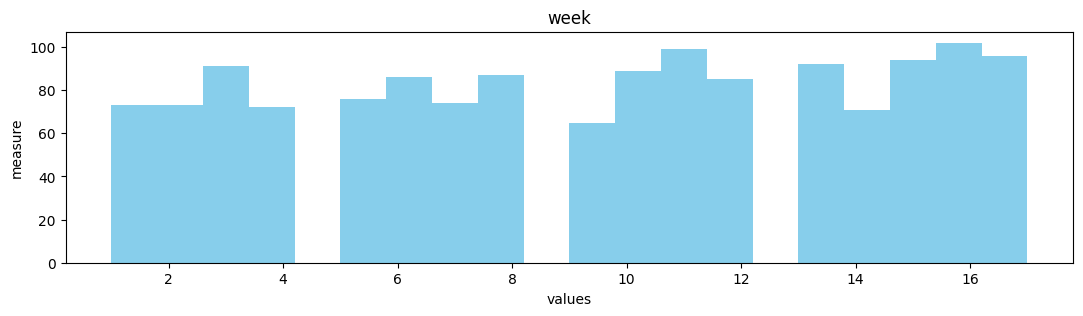

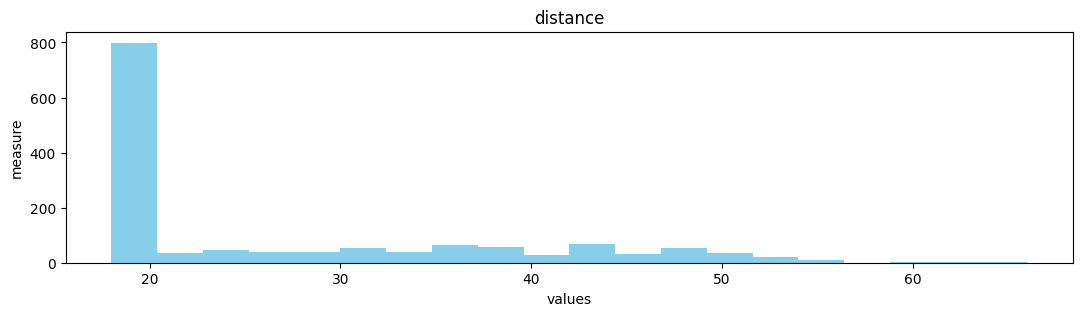

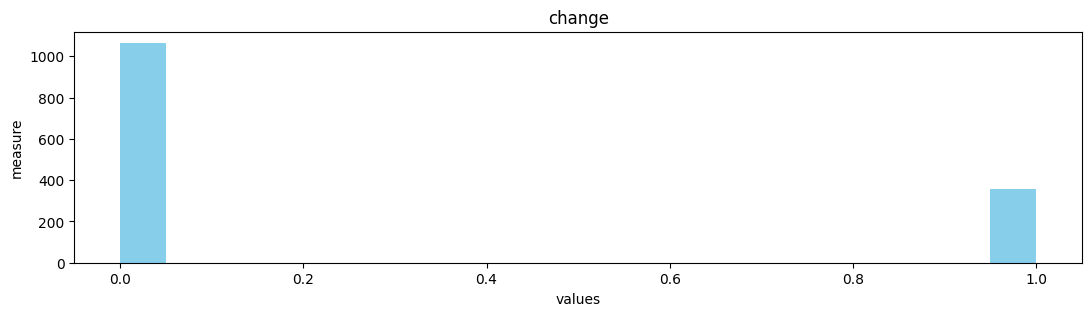

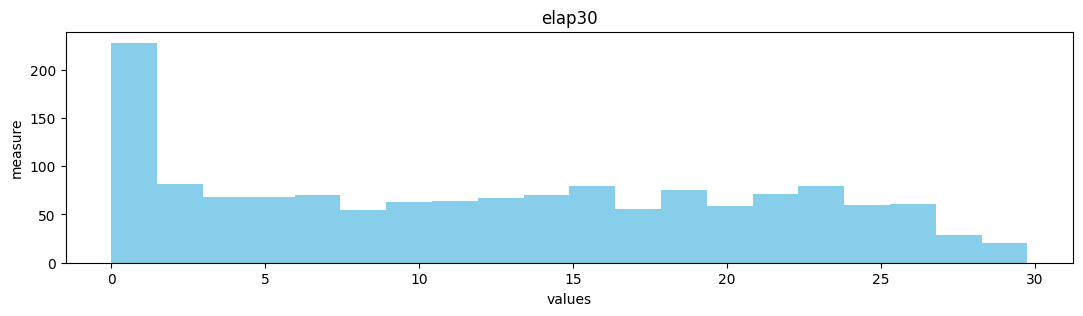

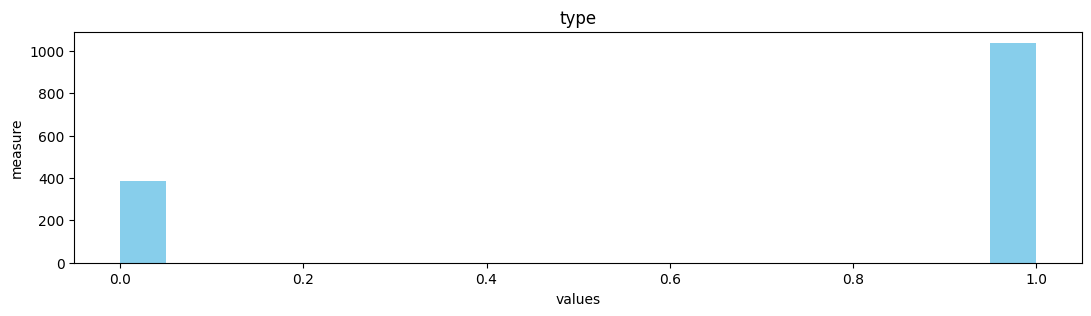

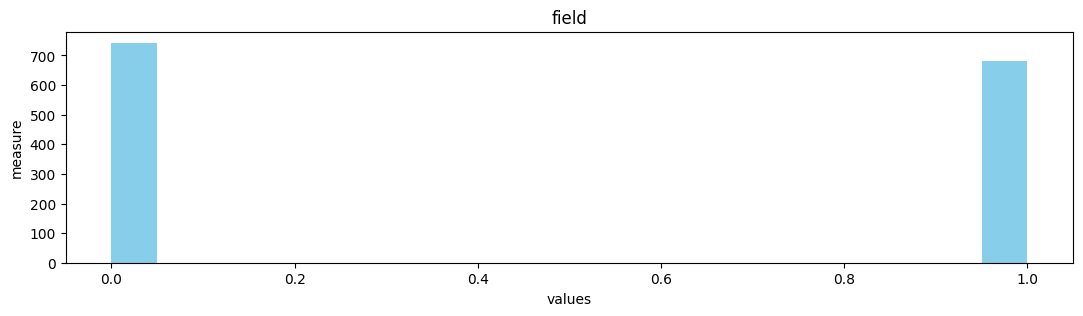

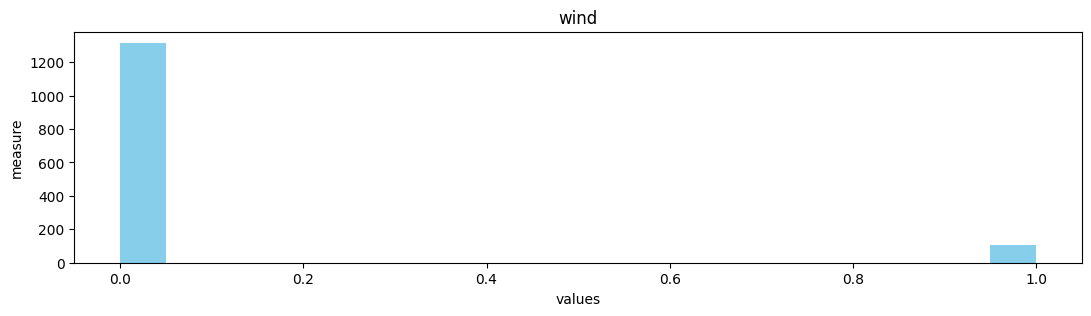

In [35]:
# Numeric datas 
for columns in features:
    plt.figure(figsize=(13, 3))
    plt.hist(df[columns], bins=20, color = "skyblue", lw=0)
    plt.title(columns)
    plt.xlabel("values")
    plt.ylabel("measure")
    plt.savefig('./output/fig {} .png'.format(columns), dpi=300)
    plt.show()

In [36]:
# Enconding Target ratio
y = df[TARGET]
display((y.value_counts()/len(df)*100).round(2).to_frame(TARGET +" (%)").T)

print("\n InputFile:")
display(df.head(10))

good,1,0
good (%),88.56,11.44



 InputFile:


,week,distance,change,elap30,type,field,wind,good
0,1,21,1,24.7167,1,1,0,1
1,1,21,0,15.8500,1,1,0,1
2,1,20,0,0.4500,1,1,0,1
3,1,28,0,13.5500,1,1,0,1
4,1,20,0,21.8667,0,0,0,1
5,1,25,0,17.6833,0,0,0,1
6,1,20,0,12.6833,0,0,0,1
7,1,27,1,4.7833,0,0,0,1
8,1,44,1,0.9167,0,0,0,1
9,1,32,0,25.7667,0,0,0,1


#### Normalization

In [37]:
# Recreates the list of features
features = list(df.columns)
features.remove(TARGET)

#Mean and Standard deviation
df[features] = df[features] - df[features].mean()
df[features] = df[features] / df[features].std()

print("Results:")
df_mean = df[features].mean().round(2).to_frame("Mean")
df_std = df[features].std().round(2).to_frame("Standard deviation")
display(df_mean.join(df_std))
    
df = df.drop(["good"], axis=1)
print("\n dataFile:")
display(df.head(5))

Results:


,Mean,Standard deviation
week,0.0,1.0
distance,-0.0,1.0
change,0.0,1.0
elap30,-0.0,1.0
type,-0.0,1.0
field,-0.0,1.0
wind,0.0,1.0



 dataFile:


,week,distance,change,elap30,type,field,wind
0,-1.697553,-0.620286,1.722578,1.420767,0.610386,1.043397,-0.286264
1,-1.697553,-0.620286,-0.580118,0.406873,0.610386,1.043397,-0.286264
2,-1.697553,-0.715054,-0.580118,-1.354093,0.610386,1.043397,-0.286264
3,-1.697553,0.043095,-0.580118,0.143872,0.610386,1.043397,-0.286264
4,-1.697553,-0.715054,-0.580118,1.094874,-1.637159,-0.957735,-0.286264


### K-Folds Cross Validation

In [38]:
def crossValidationScores(clf): 
    kfold = KFold(n_splits=N_FOLDS, shuffle=True, random_state=1)
    scores = {}
    
    #metric scores
    mean_train_acc, mean_test_acc = 0, 0
    mean_train_recall, mean_test_recall = 0, 0
    mean_train_f1, mean_test_f1 = 0, 0
    mean_train_prec, mean_test_prec = 0, 0
    
    #train, test, validation
    x_train, y_train = [], []
    x_test, y_test = [], []
    x_val, y_val = [], []
    
    x_predict, y_predict, test_predict_prob = [], [], [] #prediction
    train_acc, test_acc, val_acc = [], [], [] #accuracy
    train_recall, test_recall, val_recall = [], [], [] #recall
    train_f1, test_f1, val_f1 = [], [], [] #f1
    train_prec, test_prec, val_prec = [], [], [] #precision
    
    # enumerate splits
    for train_index, test_index in kfold.split(df):
        x_train, x_test = df.iloc[train_index], df.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        #classifier - fit train
        clf = clf.fit(x_train, y_train)
        
        #prediction
        x_predict, y_predict = clf.predict(x_train), clf.predict(x_test) 
        test_predict_prob = clf.predict_proba(x_test)
        
        train_acc.append(accuracy_score(y_train, x_predict))
        test_acc.append(accuracy_score(y_test, y_predict))
        
        train_recall.append(recall_score(y_train, x_predict))
        test_recall.append(recall_score(y_test, y_predict))
        
        train_f1.append(f1_score(y_train, x_predict))
        test_f1.append(f1_score(y_test, y_predict))
        
        train_prec.append(precision_score(y_train, x_predict))
        test_prec.append(precision_score(y_test, y_predict))

        mean_train_acc, mean_test_acc = np.mean(train_acc), np.mean(test_acc)
        mean_train_recall, mean_test_recall = np.mean(train_recall), np.mean(test_recall)
        mean_train_f1, mean_test_f1 = np.mean(train_f1), np.mean(test_f1)
        mean_train_prec, mean_test_prec = np.mean(train_prec), np.mean(test_prec)
        
        scores = {'train_acc':[] ,'test_acc':[] ,
                  'train_recall':[] ,'test_recall':[],
                  'train_f1':[],'test_f1':[],
                  'train_prec':[], 'test_prec':[]}
        
        scores['train_acc'].append(mean_train_acc)
        scores['test_acc'].append(mean_test_acc)
        scores['train_recall'].append(mean_train_recall)
        scores['test_recall'].append(mean_test_recall)
        scores['train_f1'].append(mean_train_f1)
        scores['test_f1'].append(mean_test_f1)
        scores['train_prec'].append(mean_train_prec)
        scores['test_prec'].append(mean_test_prec)

    return (scores)

In [39]:
def show_scores(scores = {}):
    print("Training:")
    print(" Accuracy: ", np.round(scores['train_acc'],4))
    print(" Recall: ", np.round(scores['train_recall'],4))
    print(" F1: ", np.round(scores['train_f1'],4))
    print(" Precision: ",np.round(scores['train_prec'],4))

    print("Test:")
    print(" Accuracy: ",np.round(scores['test_acc'],4))
    print(" Recall: ", np.round(scores['test_recall'],4))
    print(" F1: ", np.round(scores['test_f1'],4))
    print(" Precision: ", np.round(scores['test_prec'],4))

In [40]:
def show_plots(index, acc, recall, f1, prec, baseline, xlabel, title):
    
    fig, ax = plt.subplots()
    plt.axhline(baseline['test_acc'], linestyle='--', color='grey', label='baseline')
    ax.plot ( index, acc, linewidth = 1, color = 'red' , label='Accuracy')
    ax.plot ( index, recall, linewidth = 1, color = 'blue',label='Recall')
    ax.plot ( index, f1, linewidth = 1, color = 'green', label='F1')
    ax.plot ( index, prec, linewidth = 1, color = 'purple',label='Precision' )

    ax.set_xlabel(xlabel)
    ax.set_ylabel('Scores')
    ax.set_title(title)
    ax.set_xticks(index)
    ax.legend()
    plt.show()

### Naive Bayes

The Naive Bayes classifiers are a family of simple "probabilistic classifiers". We will use here as a baseline, a Gaussian curve for model classification.

In [41]:
#baseline 
gnb = GaussianNB()
baseline = crossValidationScores(gnb)

In [42]:
show_scores(baseline)

Training:
 Accuracy:  [0.8761]
 Recall:  [0.937]
 F1:  [0.9305]
 Precision:  [0.9242]
Test:
 Accuracy:  [0.8709]
 Recall:  [0.9319]
 F1:  [0.9274]
 Precision:  [0.9231]


### Decision Tree

In a decision tree, a decision is made through the path from the root node to the leaf node. The variation in height/depth of the tree is decisive in the accuracy of the model. We can see that when it is unlimited, all metrics reach the maximum. We use here a tree of height 10, to evaluate the metrics and compare with an unlimited depth.

In [43]:
Accuracy_dt_test,Accuracy_dt_train = [],[]
Recall_dt_test,Recall_dt_train = [],[]
F1_dt_test,F1_dt_train = [],[]
Precision_dt_test,Precision_dt_train = [],[]

depth =  range(1,10+1)
for d in depth:
    dtc = DecisionTreeClassifier(max_depth = d)
    dtc_score = crossValidationScores(dtc)
    Accuracy_dt_test.append(dtc_score['test_acc'])
    Recall_dt_test.append(dtc_score['test_recall'])
    F1_dt_test.append(dtc_score['test_f1'])
    Precision_dt_test.append(dtc_score['test_prec'])
    
    Accuracy_dt_train.append(dtc_score['train_acc'])
    Recall_dt_train.append(dtc_score['train_recall'])
    F1_dt_train.append(dtc_score['train_f1'])
    Precision_dt_train.append(dtc_score['train_prec'])

10


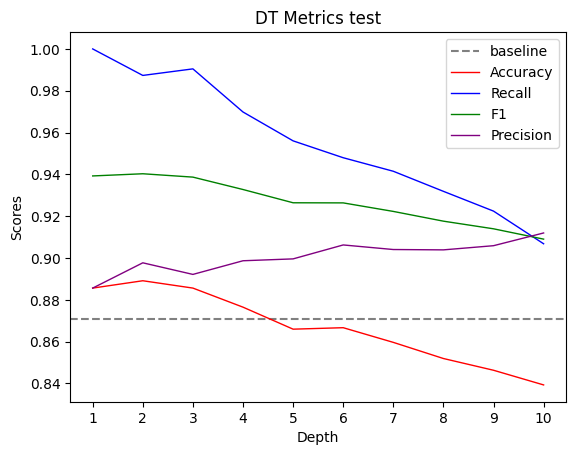

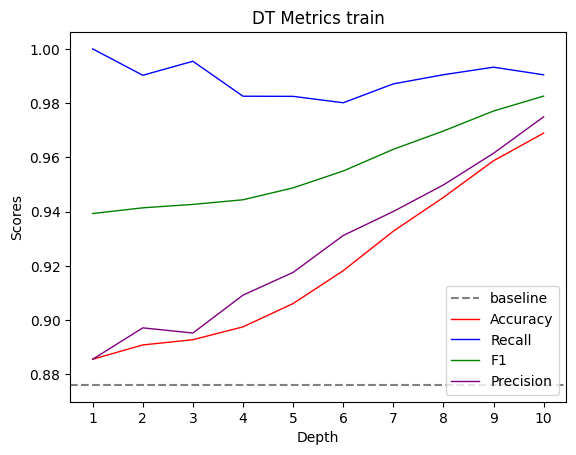

In [44]:
index = np.arange(1,10+1)

fig, ax = plt.subplots()
# print(len(baseline['test_acc']))
print(len(Accuracy_dt_test))

plt.axhline(baseline['test_acc'], linestyle='--', color='grey', label='baseline')
ax.plot ( index, Accuracy_dt_test, linewidth = 1, color = 'red' , label='Accuracy')
ax.plot ( index, Recall_dt_test, linewidth = 1, color = 'blue',label='Recall')
ax.plot ( index, F1_dt_test, linewidth = 1, color = 'green', label='F1')
ax.plot ( index, Precision_dt_test, linewidth = 1, color = 'purple',label='Precision' )

ax.set_xlabel('Depth')
ax.set_ylabel('Scores')
ax.set_title('DT Metrics test')
ax.set_xticks(index)
plt.savefig('./output/DT Metrics test.png', dpi=300)
ax.legend()

fig, ax1 = plt.subplots()
plt.axhline(baseline['train_acc'], linestyle='--', color='grey', label='baseline')
ax1.plot ( index, Accuracy_dt_train, linewidth = 1, color = 'red' , label='Accuracy')
ax1.plot ( index, Recall_dt_train, linewidth = 1, color = 'blue',label='Recall')
ax1.plot ( index, F1_dt_train, linewidth = 1, color = 'green', label='F1')
ax1.plot ( index, Precision_dt_train, linewidth = 1, color = 'purple',label='Precision' )

ax1.set_xlabel('Depth')
ax1.set_ylabel('Scores')
ax1.set_title('DT Metrics train')
ax1.set_xticks(index)
ax1.legend()
plt.savefig('./output/DT Metrics train.png', dpi=300)
plt.show()

In [45]:
dtc = DecisionTreeClassifier(max_depth = 6)
dtc_score = crossValidationScores(dtc)
show_scores(dtc_score)

Training:
 Accuracy:  [0.9184]
 Recall:  [0.9807]
 F1:  [0.9551]
 Precision:  [0.9309]
Test:
 Accuracy:  [0.8653]
 Recall:  [0.9472]
 F1:  [0.9256]
 Precision:  [0.9055]


In [46]:
dtc = DecisionTreeClassifier(max_depth = 9)
dtc_score = crossValidationScores(dtc)
show_scores(dtc_score)

Training:
 Accuracy:  [0.9579]
 Recall:  [0.9925]
 F1:  [0.9766]
 Precision:  [0.9613]
Test:
 Accuracy:  [0.8449]
 Recall:  [0.9207]
 F1:  [0.9131]
 Precision:  [0.9057]


In [47]:
dtc = DecisionTreeClassifier(max_depth = None)
dtc_score = crossValidationScores(dtc)
show_scores(dtc_score)

Training:
 Accuracy:  [1.]
 Recall:  [1.]
 F1:  [1.]
 Precision:  [1.]
Test:
 Accuracy:  [0.8288]
 Recall:  [0.8892]
 F1:  [0.9018]
 Precision:  [0.9152]


### Support Vector Machines

The SVM performs the separation of a set of objects with different classes, that is, it uses the concept of decision plans. We use here, the evaluation of the model, in different kernel. You can see that the metrics have considerable changes when the kernel changes. 

In [48]:
kernels = ['linear','sigmoid','poly','rbf']
#svc = SVC(probability=True)

Accuracy = []
Recall = []
F1 = []
Precision = [] 

for krn in kernels:
    print ("Kernel:", krn)
    svc = SVC(kernel = krn, gamma = 'auto', probability=True)
    svc_score = crossValidationScores(svc)
    show_scores(svc_score)
    print("\n")

Kernel: linear
Training:
 Accuracy:  [0.8856]
 Recall:  [1.]
 F1:  [0.9393]
 Precision:  [0.8856]
Test:
 Accuracy:  [0.8856]
 Recall:  [1.]
 F1:  [0.9393]
 Precision:  [0.8856]


Kernel: sigmoid
Training:
 Accuracy:  [0.8395]
 Recall:  [0.9233]
 F1:  [0.9106]
 Precision:  [0.8982]
Test:
 Accuracy:  [0.8372]
 Recall:  [0.9203]
 F1:  [0.9092]
 Precision:  [0.8992]


Kernel: poly
Training:
 Accuracy:  [0.8951]
 Recall:  [0.997]
 F1:  [0.9439]
 Precision:  [0.8962]
Test:
 Accuracy:  [0.887]
 Recall:  [0.9905]
 F1:  [0.9394]
 Precision:  [0.8935]


Kernel: rbf
Training:
 Accuracy:  [0.8919]
 Recall:  [1.]
 F1:  [0.9425]
 Precision:  [0.8912]
Test:
 Accuracy:  [0.8877]
 Recall:  [0.9976]
 F1:  [0.9402]
 Precision:  [0.8891]




#### Scores performed separately for comparison

In [49]:
svc = SVC(kernel = 'linear', gamma = 'auto', probability=True)
svc_score_linear = crossValidationScores(svc)

Accuracy.append(svc_score_linear['test_acc'])
Recall.append(svc_score_linear['test_recall'])
F1.append(svc_score_linear['test_f1'])
Precision.append(svc_score_linear['test_prec'])

In [50]:
svc = SVC(kernel = 'sigmoid', gamma = 'auto', probability=True)
svc_score_sigmoid = crossValidationScores(svc)

Accuracy.append(svc_score_sigmoid['test_acc'])
Recall.append(svc_score_sigmoid['test_recall'])
F1.append(svc_score_sigmoid['test_f1'])
Precision.append(svc_score_sigmoid['test_prec'])

In [51]:
svc = SVC(kernel = 'poly', gamma = 'auto', probability=True)
svc_score_poly = crossValidationScores(svc)

Accuracy.append(svc_score_poly['test_acc'])
Recall.append(svc_score_poly['test_recall'])
F1.append(svc_score_poly['test_f1'])
Precision.append(svc_score_poly['test_prec'])

In [52]:
svc = SVC(kernel = 'rbf', gamma = 'auto', probability=True)
svc_score_rbf = crossValidationScores(svc)

Accuracy.append(svc_score_rbf['test_acc'])
Recall.append(svc_score_rbf['test_recall'])
F1.append(svc_score_rbf['test_f1'])
Precision.append(svc_score_rbf['test_prec'])

#### We can see that the Recall metrics overlap with the other metrics.

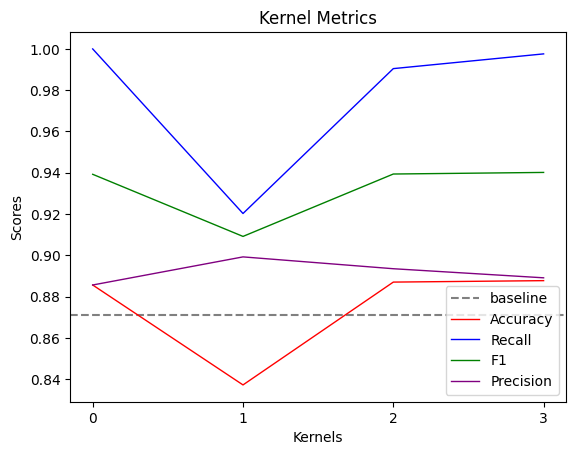

In [53]:
label = ['Linear','Sigmoid','Polinomial','RBF'] 
# index = np.arange(len(label))
width = 0.35  # the width of the bars
index = np.arange(0,len(label))

fig, ax = plt.subplots()
plt.axhline(baseline['test_acc'], linestyle='--', color='grey', label='baseline')
ax.plot ( (index), Accuracy, linewidth = 1, color = 'red' , label='Accuracy')
ax.plot ( (index), Recall, linewidth = 1, color = 'blue',label='Recall')
ax.plot ( (index), F1, linewidth = 1, color = 'green', label='F1')
ax.plot ( (index), Precision, linewidth = 1, color = 'purple',label='Precision' )

ax.set_xlabel('Kernels')
ax.set_ylabel('Scores')
ax.set_title('Kernel Metrics')
ax.set_xticks(index)
ax.legend()
plt.savefig('./output/Kernel Metrics.png', dpi=300)
plt.show()

In [54]:
dfplot = pd.DataFrame({'Accuracy': Accuracy,'Recall': Recall,'F1':F1, 'Precision': Precision}, index=index)

### k-Nearest Neighbors

O k-NN é um modelo quen realiza a classificação de pontos dados seus k-vizinhos. 

In [55]:
Accuracy_knn_test,Accuracy_knn_train = [],[]
Recall_knn_test,Recall_knn_train = [],[]
F1_knn_test,F1_knn_train = [],[]
Precision_knn_test,Precision_knn_train = [],[]

neighbors = [i for i in range(3, 17+1, 2)]
for n in neighbors:
    knn = KNeighborsClassifier(n_neighbors=n)
    knn_score = crossValidationScores(knn)
    Accuracy_knn_test.append(knn_score['test_acc'])
    Accuracy_knn_train.append(knn_score['train_acc'])
    Recall_knn_test.append(knn_score['test_recall'])
    Recall_knn_train.append(knn_score['train_recall'])
    F1_knn_test.append(knn_score['test_f1'])
    F1_knn_train.append(knn_score['train_f1'])
    Precision_knn_test.append(knn_score['test_prec'])
    Precision_knn_train.append(knn_score['train_prec'])
    print(knn_score)

{'train_acc': [0.9166666666666666], 'test_acc': [0.8659649122807018], 'train_recall': [0.9776067927617133], 'test_recall': [0.9501407376799034], 'train_f1': [0.9540784001914389], 'test_f1': [0.9261787490293228], 'train_prec': [0.9316576297138305], 'test_prec': [0.903736007756741]}
{'train_acc': [0.9014035087719299], 'test_acc': [0.8701754385964913], 'train_recall': [0.9789906288973036], 'test_recall': [0.9596092857167424], 'train_f1': [0.9461900523295623], 'test_f1': [0.9289425216713691], 'train_prec': [0.9155244146015956], 'test_prec': [0.9004757258558695]}
{'train_acc': [0.8947368421052632], 'test_acc': [0.8750877192982456], 'train_recall': [0.9790033640761487], 'test_recall': [0.969827984694388], 'train_f1': [0.9427668784925457], 'test_f1': [0.9320865853775299], 'train_prec': [0.9091343059843894], 'test_prec': [0.8973040044353155]}
{'train_acc': [0.8914035087719299], 'test_acc': [0.8757894736842105], 'train_recall': [0.9857311230693984], 'test_recall': [0.9770630934524412], 'train_f

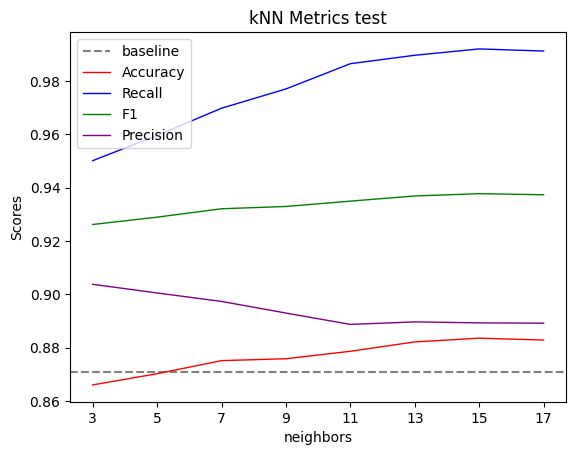

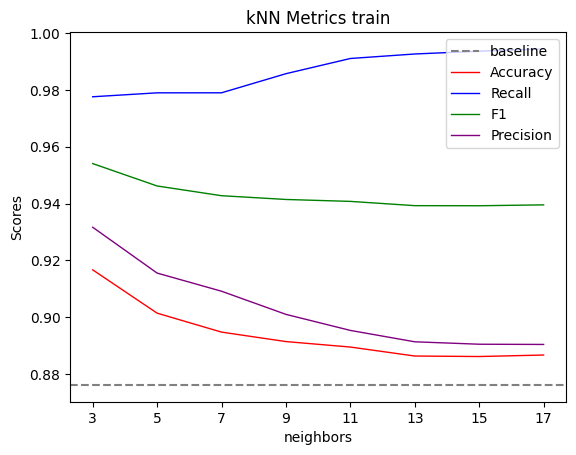

In [56]:
index = neighbors

fig, ax = plt.subplots()
plt.axhline(baseline['test_acc'], linestyle='--', color='grey', label='baseline')
ax.plot ( index, Accuracy_knn_test, linewidth = 1, color = 'red' , label='Accuracy')
ax.plot ( index, Recall_knn_test, linewidth = 1, color = 'blue',label='Recall')
ax.plot ( index, F1_knn_test, linewidth = 1, color = 'green', label='F1')
ax.plot ( index, Precision_knn_test, linewidth = 1, color = 'purple',label='Precision' )

ax.set_xlabel('neighbors')
ax.set_ylabel('Scores')
ax.set_title('kNN Metrics test')
ax.set_xticks(index)
ax.legend()
plt.savefig('./output/KNN test', dpi=300)
fig, ax1 = plt.subplots()
plt.axhline(baseline['train_acc'], linestyle='--', color='grey', label='baseline')
ax1.plot ( index, Accuracy_knn_train, linewidth = 1, color = 'red' , label='Accuracy')
ax1.plot ( index, Recall_knn_train, linewidth = 1, color = 'blue',label='Recall')
ax1.plot ( index, F1_knn_train, linewidth = 1, color = 'green', label='F1')
ax1.plot ( index, Precision_knn_train, linewidth = 1, color = 'purple',label='Precision' )

ax1.set_xlabel('neighbors')
ax1.set_ylabel('Scores')
ax1.set_title('kNN Metrics train')
ax1.set_xticks(index)
ax1.legend()
plt.savefig('./output/KNN train', dpi=300)
plt.show()

### Random Forest

In [57]:
Accuracy_rfc_test,Accuracy_rfc_train = [],[]
Recall_rfc_test,Recall_rfc_train = [],[]
F1_rfc_test,F1_rfc_train = [],[]
Precision_rfc_test,Precision_rfc_train = [],[]

rf = [i for i in range(1,50+1, 2)]
for n in rf:
    rfc = RandomForestClassifier(n_estimators=n)
    rfc_score = crossValidationScores(rfc)
    Accuracy_rfc_test.append(rfc_score['test_acc'])
    Accuracy_rfc_train.append(rfc_score['train_acc'])
    Recall_rfc_test.append(rfc_score['test_recall'])
    Recall_rfc_train.append(rfc_score['train_recall'])
    F1_rfc_test.append(rfc_score['test_f1'])
    F1_rfc_train.append(rfc_score['train_f1'])
    Precision_rfc_test.append(rfc_score['test_prec'])
    Precision_rfc_train.append(rfc_score['train_prec'])

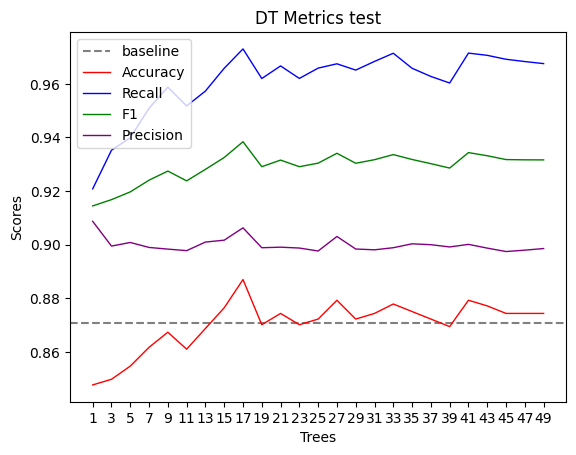

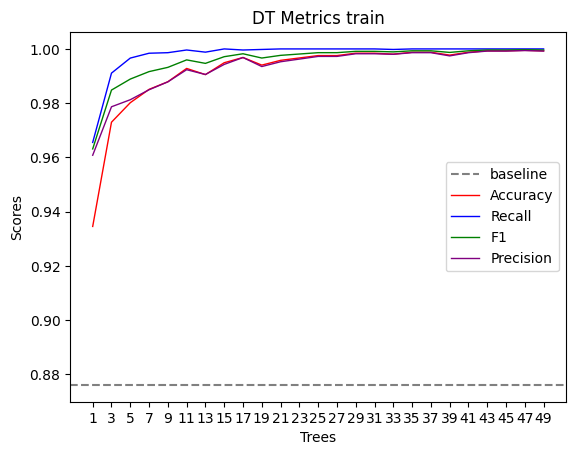

In [58]:
index = rf 

fig, ax = plt.subplots()
plt.axhline(baseline['test_acc'], linestyle='--', color='grey', label='baseline')
ax.plot ( index, Accuracy_rfc_test, linewidth = 1, color = 'red' , label='Accuracy')
ax.plot ( index, Recall_rfc_test, linewidth = 1, color = 'blue',label='Recall')
ax.plot ( index, F1_rfc_test, linewidth = 1, color = 'green', label='F1')
ax.plot ( index, Precision_rfc_test, linewidth = 1, color = 'purple',label='Precision' )

ax.set_xlabel('Trees')
ax.set_ylabel('Scores')
ax.set_title('DT Metrics test')
ax.set_xticks(index)
ax.legend()
plt.savefig('./output/DT test.png', dpi=300)

fig, ax1 = plt.subplots()
plt.axhline(baseline['train_acc'], linestyle='--', color='grey', label='baseline')
ax1.plot ( index, Accuracy_rfc_train, linewidth = 1, color = 'red' , label='Accuracy')
ax1.plot ( index, Recall_rfc_train, linewidth = 1, color = 'blue',label='Recall')
ax1.plot ( index, F1_rfc_train, linewidth = 1, color = 'green', label='F1')
ax1.plot ( index, Precision_rfc_train, linewidth = 1, color = 'purple',label='Precision' )

ax1.set_xlabel('Trees')
ax1.set_ylabel('Scores')
ax1.set_title('DT Metrics train')
ax1.set_xticks(index)
ax1.legend()
plt.savefig('./output/DT train', dpi=300)
plt.show()